## Rock Physics

In this second lab of the *ErSE 210 - Seismology* course, we will look at some of the Rock Physics equations we have learned in our lecture.

More specifically we will implmented **Gassman fluid substitution** and use it on a Well-Log suite from a well in the North Sea, more specifically the 32/2-1 well in the [Smehaia](https://data.equinor.com) region, Hordaland Platform offshore Norway, which is currently being proposed as an area suitable for a CO2 storage site.

In this lab, we will make use of several routines implemented in utilities files, feel free to open them and investigate in more details how things have been implemented.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import rockphysics.elastic as el
import rockphysics.bounds as bd

from rockphysics.elastic import Elastic, ElasticLimited
from rockphysics.solid import Matrix, Rock
from rockphysics.fluid import _batze_wang_brine, Brine, Gas, Oil, Fluid
from rockphysics.gassmann import Gassmann
from rockphysics.units import *
from rockphysics.wavelets import *
from rockphysics.Logs import *

## Mixing laws

First of all we briefly look at different mixing laws. Let's start by defining two minerals and compute their Reuss, Voigt, and Hashin-Shtrikman bounds.

Voigt: $M = \sum_i f_i M_i \quad M=K,\mu$

Reuss: $1/M = \sum_i f_i/M_i \quad M=K,\mu$

H-S: $K^{HS}=K_1+\frac{f_2}{(K_2-K_1)^{-1}+f_1(K_1+4 \mu_1/3)^{-1}}$ and similar relation for $\mu$

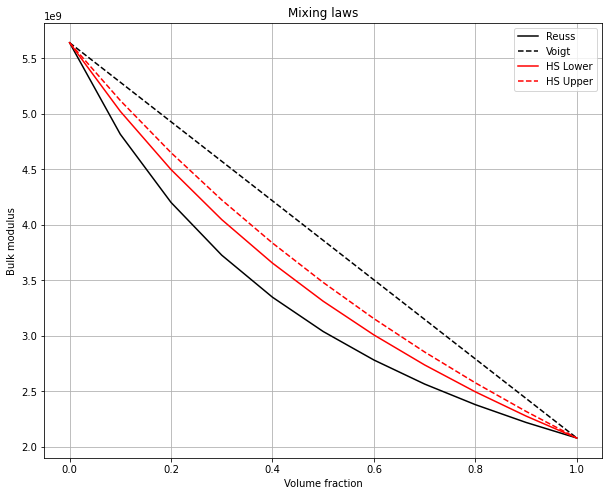

In [2]:
# First elastic medium (quartz)
vp = 2000
vs = 1200
rho = 1000
quartz = Elastic(vp, vs, rho)

# Second elastic medium (clay)
vp = 2600
vs = 1500
rho = 1500
clay = Elastic(vp, vs, rho)

# Fractions
f = np.arange(0, 1.1, 0.1)

# Mixing laws
reuss = np.zeros(len(f))
voigt = np.zeros(len(f))
hashin_shtrikman_lower = np.zeros(len(f))
hashin_shtrikman_upper = np.zeros(len(f))

for i in range(len(f)):   
    reuss[i] = bd.reuss_bound([f[i], 1-f[i]], [quartz.k, clay.k])
    voigt[i] = bd.voigt_bound([f[i], 1-f[i]], [quartz.k, clay.k])
    hashin_shtrikman_lower[i], hashin_shtrikman_upper[i] = \
        bd.hashin_shtrikman([f[i], 1-f[i]], [quartz.k, clay.k], [quartz.mu, clay.mu])

plt.figure(figsize=(10, 8))
plt.plot(f, reuss, 'k', label='Reuss')
plt.plot(f, voigt, '--k', label='Voigt')
plt.plot(f, hashin_shtrikman_lower, 'r', label='HS Lower')
plt.plot(f, hashin_shtrikman_upper, '--r', label='HS Upper')
plt.xlabel('Volume fraction')
plt.ylabel('Bulk modulus')
plt.title('Mixing laws')
plt.legend()
plt.grid()
plt.axis('tight');

This graph gives us an idea of the allowed values of the Bulk modulus of the mix of two minerals for each volume fraction. We can easily observe how the Hashin-Shtrikman is stricter than the Reuss-Voigt bound providing a smaller range of allowed values.

## Gassmann fluid substitution

We can now turn our attention to one of the key equations required to model different scenarios when performing 3D or 4D seismic feasibility studies. The **Gassmann equations** provide a framework to substitute fluids in the pore space of a rock and compute how that change affects the elastic properties.

### Single depth level

We will follow the equations described in this [paper](https://www.spgindia.org/geohorizon/jan_2006/dhananjay_paper.pdf) as well as use the same numbers used in their example to validate our implementation of the equations.

To start we create a **Matrix** and compute its bulk modulus based on Voigt-Reuss-Hill average (average of Voigt and Reus bounds)

In [3]:
mat = Matrix({'sand': {'k': 36.6e9, 'rho': g_cm3_to_kg_m3(2.65), 'frac':0.86},
              'shale': {'k': 20.9e9, 'rho': g_cm3_to_kg_m3(2.58), 'frac':0.14}})
print(mat)
print('Matrix Bulk modulus:', mat.k)
print('Matrix Density:', mat.rho)

Matrix
------
sand : 0.86
shale : 0.14

Matrix Bulk modulus: 33759576500.129883
Matrix Density: 2640.2


Let's move on to defining our **Fluids** where we will use Baltze and Wang relationships between fluid parameters (eg., salinity, temperation, gas and oil gravity, etc.) and their elastic properties

In [4]:
# Input parameters
oilgrav = 42
gasgrav = 0.9
pres = psi_to_Pa(3200)*1e-3
temp = 150
sal = 3800
gor = 160

# Brine, Oil, and Gas
wat = Brine(temp, pres, sal)
oil = Oil(temp, pres, oilgrav, gasgrav, gor)
gas = Gas(temp, pres, gasgrav)
print(wat)
print(oil)
print(gas)

Elastic medium:
---------------
VP: 1527.0316809440271
VS: 0
Rho: 933.1956506670521

Elastic medium:
---------------
VP: 630.829552640418
VS: 0
Rho: 552.6214860297605

Elastic medium:
---------------
VP: 508.84628723116697
VS: 0
Rho: 181.89858127346812



We can now mix the different consistuents to create our input fluid of interest. In this case we assume that the pore space of our rock is 100% filled with oil.

In [5]:
fluid0 = Fluid({'water': (wat, 0.),
                'oil': (oil, 1.),
                'gas': (gas, 0.)})
print(fluid0)

Fluid
------
water : 0.0
oil : 1.0
gas : 0.0



At this point we need combine the matrix and fluid and create a **Rock**

In [6]:
# Elastic properties
vp = ft_to_m(11000)
vs = ft_to_m(6500)
rho = g_cm3_to_kg_m3(2.2)
poro = 0.2

rock = Rock(vp, vs, rho, mat, fluid0, poro=poro)

Finally we perform fluid substitution. We first define how we want our new fluid to be. In this case we want the initial oil in place to be fully replaced by water.

In [7]:
fluid1 = Fluid({'water': (wat, 1.),
                'oil': (oil, 0.),
                'gas': (gas, 0.)})
print(fluid1)

Fluid
------
water : 1.0
oil : 0.0
gas : 0.0



And then we are ready to implement the equations that were shown to you in the class.

In [8]:
kdry = rock.kdry
kmatrix = rock.matrix.k
ksat1 = kdry + (1 - kdry / kmatrix) ** 2 / (
        rock.poro / fluid1.k + (1 - rock.poro) /
        kmatrix - kdry / kmatrix ** 2)

musat1 = rock.mu
rhosat1 = rock.matrix.rho * (1 - rock.poro) + \
          fluid1.rho * rock.poro
vpsat1 = np.sqrt((ksat1 + 4./3.*musat1)/rhosat1)
vssat1 =  np.sqrt(musat1/rhosat1)

rock1 = Rock(vpsat1, vssat1, rhosat1,
             rock.matrix, fluid1,
             rock.poro)

print('Medium 0:', rock)
print('Medium 1:', rock1)

Medium 0: Elastic medium:
---------------
VP: 3355.0
VS: 1982.5
Rho: 2200.0

Medium 1: Elastic medium:
---------------
VP: 3492.1006965189918
VS: 1939.4296210608754
Rho: 2298.7991301334105



We can also use the `Gassman` class that I provide to do this is a single line of code (but if you look inside you will see pretty much what I wrote in the above cell)

In [9]:
fluidsub = Gassmann(rock, fluid1, mask=False)
print('Medium 0:', fluidsub.medium0)
print('Medium 1:', fluidsub.medium1)

Medium 0: Elastic medium:
---------------
VP: 3355.0
VS: 1982.5
Rho: 2200.0

Medium 1: Elastic medium:
---------------
VP: 3492.1006965189918
VS: 1939.4296210608754
Rho: 2298.7991301334105



Note that both VP and Rho increase as we move from an Oil saturated rock to Water saturated rock. This is expected as Water is denser than Oil. However, an interesting observation is that VS sligthly decreases.

### Smehaia 32/2-1 well

Finally we go one step further and do this using a suite of well logs from a real well in the North Sea. For this I will provide you with some code that can help handling log data in the well-know LAS format as well as to easily create nice looking displays.

In [10]:
# Load log data
logs = Logs('../data/32_2-1')

# Make regular axis
logs.logs.index[:] = np.linspace(logs.logs.index[10], logs.logs.index[-1], len(logs.logs.index))

In [11]:
# Print logs
print(logs.logs.curves)

Mnemonic                                                  Unit     Value  Description                                                       
--------                                                  ----     -----  -----------                                                       
DEPT:1                                                    m               DEPTH                                                             
INPUTINTERVALVELOCITY-(STUDY1)32/2-1SYNTHETICGENERATION   m/s             Input interval velocity - (Study 1) 32/2-1 Synthetic generation   
OUTPUTINTERVALVELOCITY-(STUDY1)32/2-1SYNTHETICGENERATION  m/s             Output interval velocity - (Study 1) 32/2-1 Synthetic generation  
RC-(STUDY1)32/2-1SYNTHETICGENERATION                      _               RC - (Study 1) 32/2-1 Synthetic generation                        
DRIFT-(STUDY1)32/2-1SYNTHETICGENERATION                   ms              Drift - (Study 1) 32/2-1 Synthetic generation                     
AI           

Let's add some derived log curves

In [12]:
logs.add_curve(ft_to_m(1/logs.logs['DT']) * 1e6, 'VP', unit='ms/s')
#logs.add_curve(ft_to_m(1/logs.logs['DTS']) * 1e6, 'VS', unit='ms/s')
#logs.add_curve(ft_to_m(1/logs.logs['DT']) / ft_to_m(1/logs.logs['DTS']), 
#               'VPVS', unit='ms/')
logs.add_curve(logs.logs['VP']/2, 'VS', unit='ms/s') # given lack of good VS log we fake it
logs.add_curve(logs.logs['VP']/logs.logs['VS'], 'VPVS', unit='')
logs.add_curve(np.zeros_like(logs.logs['DT']), 'VCARB')
logs.add_curve(np.zeros_like(logs.logs['DT']), 'VCOAL')
logs.add_curve(np.zeros_like(logs.logs['DT']), 'SGE')
logs.add_curve(1-logs.logs['SWE'], 'SOE')

In [13]:
logs.display(nrows=5)

,INPUTINTERVALVELOCITY-(STUDY1)32/2-1SYNTHETICGENERATION,OUTPUTINTERVALVELOCITY-(STUDY1)32/2-1SYNTHETICGENERATION,RC-(STUDY1)32/2-1SYNTHETICGENERATION,DRIFT-(STUDY1)32/2-1SYNTHETICGENERATION,AI,RESAMPLEDAI,AC:1,AC:2,ACS:1,ACS:2,...,VSH,ZCOR,GENERALTIME1,VP,VS,VPVS,VCARB,VCOAL,SGE,SOE
DEPT:1,,,,,,,,,,,,,,,,,,,,,
581.101200,1470.777588,1470.777588,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
581.728169,1470.777588,1470.777588,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,NaN
582.355139,1470.777588,1470.777588,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,238.629364,NaN,NaN,NaN,0.0,0.0,0.0,NaN
582.982108,1470.777588,1470.777588,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,245.448318,NaN,NaN,NaN,0.0,0.0,0.0,NaN
583.609078,1470.777588,1470.777588,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,257.101044,NaN,NaN,NaN,0.0,0.0,0.0,NaN


Let's now visualize a suite of logs

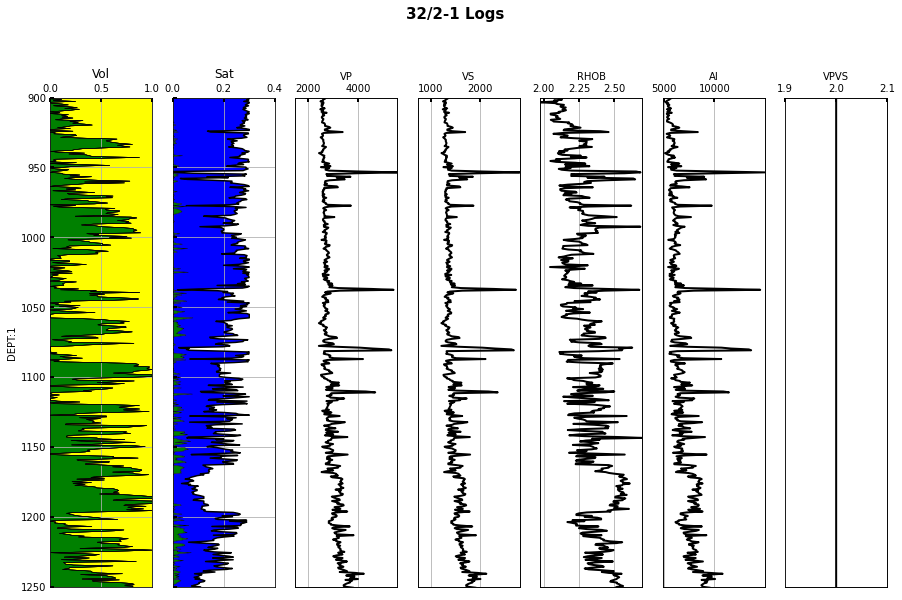

In [14]:
fig, axs = logs.view_logtrack(template='rock', cali='CALI:1', gr='GR:1', 
                              sgt='SGE', sot='SOE',
                              depth='DEPT:1', phi='PHIT:1', ylim=(900, 1250),
                              figsize=(15, 9))
fig.suptitle('32/2-1 Logs', fontsize=15, fontweight='bold', y=1.02);

We are now ready to perform fluid substitution. To mimic CO2 injection we will replace water and oil with gas in a formation with good sand content and good porosity.

First we are going to recreate the sand, shale, water, oil, and gas objects. We can then use the routine `fluid_substitution` that will extract the logs of interest and apply the Gassmann equation based on the change we want to apply as defined in the dictionary `change`

In [15]:
sand = {'k': 36.6e9, 'rho': g_cm3_to_kg_m3(2.65)}
shale = {'k': 20.9e9, 'rho': g_cm3_to_kg_m3(2.58)}

wat = Brine(temp, pres, sal)
oil = Oil(temp, pres, oilgrav, gasgrav, gor)
gas = Gas(temp, pres, gasgrav)

change = {'zmin':1195, 'zmax':1230, 'swt':0.5, 'sot':0.0, 'sgt':0.5}

#vp1_func, vs1_func, rho1_func, so1_func, sg1_func = \
logs.fluid_substitution(sand, shale, 
                        oil, wat, change, gas=gas,
                        sgt='SGE', sot='SOE', phi='PHIT:1',
                        lfp=False, savelogs=True, savedeltas=True, 
                        logssuffix='gas');

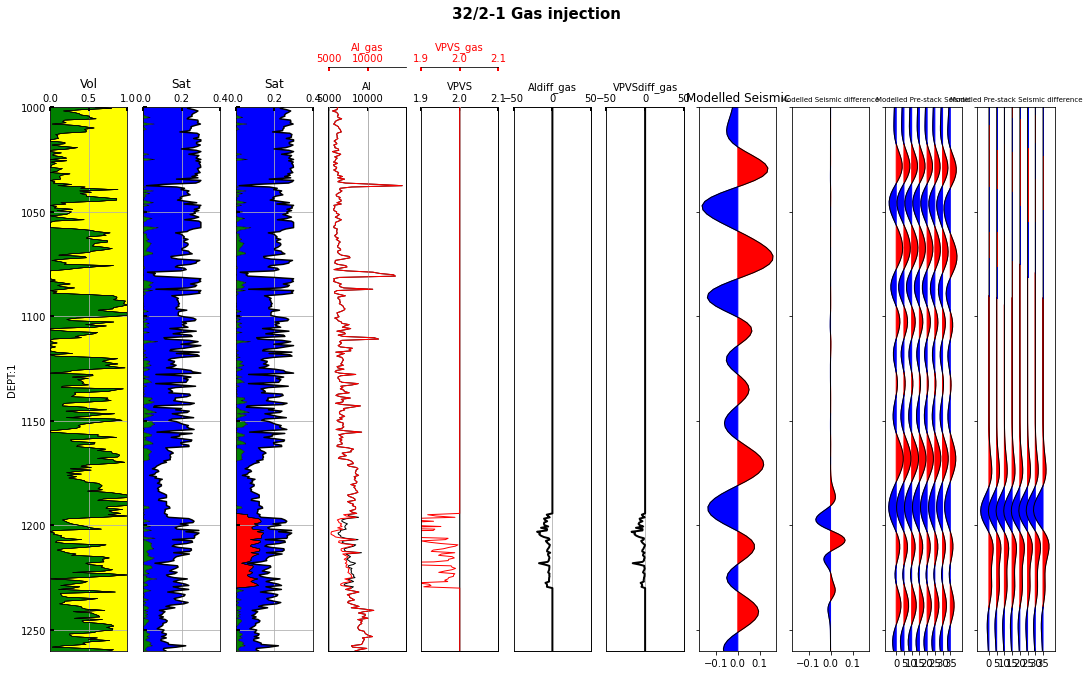

In [16]:
wav, twav, wcenter = ricker(np.arange(201)*0.004, 10, plotflag=False)

fig, axs = logs.view_logtrack(template='4Dmod', cali='CALI:1', gr='GR:1', 
                              sgt='SGE', sot='SOE',
                              depth='DEPT:1', phi='PHIT:1', 
                              wav=wav, seissampling=2.,
                              scenario4d='gas', 
                              ylim=(1000, 1260), 
                              figsize=(18, 10))
fig.suptitle('32/2-1 Gas injection', fontsize=15, fontweight='bold', y=1.02);

From this result we can see that gas injection will lead to a decrease in both Acoustic Impedance and VP/VS, which are the drivers for changes in seismic responses at near and far offset. We will learn more about this when we will look at how plane waves propagate across an interface, but for now we can already appreciate the importance of linking rock properties to elastic properties and ultimately to seismic waves - this is what every geophysicist should do before starting to interpret their seismic data!